<a href="https://www.kaggle.com/code/wamaithanyamu/cisco-timeseries-model-applied-to-stocks-forex-c?scriptVersionId=286811861" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install gitpython yfinance torch pandas numpy matplotlib

In [2]:
import os
import git

# Define the target directory path
repo_path = '/kaggle/working/cisco-time-series-model'
repo_url = 'https://github.com/splunk/cisco-time-series-model.git'

# Check if the directory exists
if os.path.isdir(repo_path):
    print(f"Directory '{repo_path}' already exists. Skipping clone.")
else:
    print(f"Directory '{repo_path}' not found. Cloning repository...")
    try:
        git.Repo.clone_from(repo_url, repo_path)
        print("Cloning complete.")
    except git.exc.GitCommandError as e:
        print(f"Error during cloning: {e}")

Directory '/kaggle/working/cisco-time-series-model' already exists. Skipping clone.


In [3]:
import sys
sys.path.append('/kaggle/working/cisco-time-series-model')

In [4]:
!pip install -r "/kaggle/working/cisco-time-series-model/requirements.txt"

In [5]:
!touch /kaggle/working/cisco-time-series-model/__init__.py


In [6]:
import sys
import os

# 1. Define the directory that CONTAINS the package folder
# This is /kaggle/working/
parent_dir = os.path.abspath('/kaggle/working/')

# 2. Add this parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

print(f"Added {parent_dir} to sys.path.")

Added /kaggle/working to sys.path.


In [7]:
import sys
import os

# Define the folder that CONTAINS the 'modeling' module
module_parent_dir = os.path.abspath('/kaggle/working/cisco-time-series-model/1.0-preview')

# Add this specific directory to sys.path
if module_parent_dir not in sys.path:
    sys.path.append(module_parent_dir)

# Now, you can import 'modeling' directly
from modeling import (
    CiscoTsmMR,
    TimesFmHparams,
    TimesFmCheckpoint
)

print("Successfully imported classes by correcting the path and structure.")

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0].
Successfully imported classes by correcting the path and structure.


In [8]:
import torch
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Union
import pandas as pd
import numpy as np

# 💻 Determine device (CPU or CUDA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🌍 Running on device: {DEVICE}")


🌍 Running on device: cuda


# Deriv API Configs

Deriv broker offers a handful of snthetically generated assets and I thought it would be good to see how this model performs on assets that are computer generated. Can this model pick up the under;ying patterns that power the synthetic generator?

To get your APP ID and token please follow this [guide](https://docs.google.com/document/d/1R0nvI5nL_-pqkqSJCsdvU0_xzFqbiwhpDr74mkuLtqo/edit?usp=sharing)

In [9]:
# kaggle secrets here if on kaggle

from kaggle_secrets import UserSecretsClient

# ---------------------------------------------------------
# 🔑 DERIV API CONSTANTS
# ---------------------------------------------------------

try:
    # Initialize the secrets client
    secrets = UserSecretsClient()

    # Get the main secret string (assuming the token is stored as the primary secret)
    DEFAULT_TOKEN = secrets.get_secret("deriv_api")
    print("🔑 Deriv Token loaded securely.")

    # Get a custom secret key (assuming the App ID is stored as a custom key 'app_id')
    # Note: KaggleSecrets returns strings, so it must be converted to an integer.
    APP_ID = int(secrets.get_secret("deriv_app_id"))
    print("🆔 Deriv App ID loaded securely.")

except Exception as e:
    # Fallback to placeholders if running outside Kaggle or secret is missing/incorrect
    print(f"⚠️ Warning: Failed to load secrets from Kaggle ({e}). Falling back to dummy values.")
    APP_ID = 1234
    DEFAULT_TOKEN = "YOUR-TOKEN-GOES-HERE"





🔑 Deriv Token loaded securely.
🆔 Deriv App ID loaded securely.


In [10]:
# =========================================================
# 🔗 NEW DATA SOURCE: Deriv API Client for OHLC
# =========================================================
import asyncio
import json
import ssl
import time
import os
import sys
from collections import deque, Counter
from decimal import Decimal, InvalidOperation
import certifi
import websockets
from concurrent.futures import Future
import threading

class DerivOHLCFetcher:
    def __init__(self, token: str, app_id: int):
        self.token = token
        self.app_id = app_id
        self.uri = f"wss://ws.derivws.com/websockets/v3?app_id={app_id}"
        self.ws = None
        self.reader_task = None
        # ❌ REMOVED: self.resp_queue = asyncio.Queue() from here

    async def connect_and_authorize(self):
        try:
            # ✅ FIXED: Initialize the queue inside the running event loop
            self.resp_queue = asyncio.Queue() 
            
            print("🔗 Connecting securely to Deriv WebSocket...")
            self.ws = await websockets.connect(self.uri, open_timeout=10)
            self.reader_task = asyncio.create_task(self._reader_loop())
            
            await self.ws.send(json.dumps({"authorize": self.token}))
            msg = await asyncio.wait_for(self.resp_queue.get(), timeout=10)
            
            if "error" in msg:
                print(f"💥 Authorization error: {msg['error'].get('message')}")
                return False
            
            print(f"✅ Authorized! Login ID: {msg['authorize'].get('loginid')}")
            return True
        except Exception as e:
            print(f"❌ Connection/Authorization failed: {e}")
            return False

    async def _reader_loop(self):
        try:
            async for raw in self.ws:
                msg = json.loads(raw)
                if isinstance(msg, dict) and any(k in msg for k in ("authorize", "error", "candles", "prices")):
                    await self.resp_queue.put(msg)
        except Exception:
            pass 

    async def fetch_ohlc(self, symbol: str, granularity: int, count: int) -> pd.DataFrame | None:
        if not await self.connect_and_authorize():
            return None

        # Request logic remains same...
        style = "candles" if granularity >= 60 else "ticks"
        payload = {
            "ticks_history": symbol,
            "count": count,
            "end": "latest",
            "style": style
        }
        if granularity >= 60:
            payload["granularity"] = granularity
            
        print(f"⏳ Requesting {count} {style} for {symbol}...")
        await self.ws.send(json.dumps(payload))
        
        try:
            resp = await asyncio.wait_for(self.resp_queue.get(), timeout=30)
            if "error" in resp:
                print(f"💥 API Error: {resp['error'].get('message')}")
                return None
            
            data_key = 'candles' if granularity >= 60 else 'prices'
            candles = resp.get(data_key, [])
            
            if not candles:
                print("⚠️ No data returned from API.")
                return None
            
            print(f"✅ Loaded {len(candles)} points.")
            
            if granularity >= 60:
                df = pd.DataFrame(candles)
            else:
                df = pd.DataFrame({'epoch': resp.get('times', []), 'close': resp.get('prices', [])})
            
            df['date'] = pd.to_datetime(df['epoch'], unit='s')
            df.set_index('date', inplace=True)
            df['Close'] = df['close']
            return df[['Close']].copy()
        except Exception as e:
            print(f"❌ Error during OHLC fetch: {e}")
            return None
        finally:
            if self.ws: await self.ws.close()
            if self.reader_task: self.reader_task.cancel()
# =========================================================
# 💡 KAGGLE/NOTEBOOK ASYNC FIX HELPER FUNCTION
# =========================================================

def _sync_fetch_ohlc_threaded(fetcher, symbol, granularity, count):
    """Executes the async fetcher in a new thread with its own event loop."""
    print("⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...")
    
    def run_async_in_thread(future_obj):
        new_loop = asyncio.new_event_loop()
        asyncio.set_event_loop(new_loop)
        try:
            result = new_loop.run_until_complete(fetcher.fetch_ohlc(
                symbol=symbol,
                granularity=granularity,
                count=count
            ))
            future_obj.set_result(result)
        finally:
            new_loop.close()

    future = Future()
    thread = threading.Thread(target=run_async_in_thread, args=(future,))
    thread.start()
    thread.join() # Wait for the thread to complete its work
    return future.result()


# Core functionality

In [11]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import List, Dict, Union, Optional

class CiscoTsmModel:
    """
    A class to fetch financial data (yfinance/Deriv), initialize the CiscoTsmMR
    model, and generate forecasts compared against unseen holdout points.
    """
    def __init__(
        self, 
        ticker: str, 
        start_date: str, 
        coarse_start: str, 
        end_date: str, 
        zoom_bars: int = 50, 
        prediction_length: int = 76, 
        holdout_points: int = 20, # 🛑 Hidden points for comparison
        deriv: bool = False, 
        count: int = 5000,
        fine_tf: str = "1m",       
        coarse_tf: str = "1h",     
        fine_gran: int = 60,       
        coarse_gran: int = 3600    
    ):
        # 📥 Data Parameters
        self.TICKER = ticker
        self.START_DATE = start_date
        self.COARSE_START = coarse_start
        self.END_DATE = end_date
        self.DERIV_OR_YFINANCE = deriv
        self.COUNT = count
        
        # 🔄 Timeframe / Granularity Parameters
        self.FINE_TF = fine_tf
        self.COARSE_TF = coarse_tf
        self.FINE_GRAN = fine_gran
        self.COARSE_GRAN = coarse_gran

        # 💾 Data Storage
        self.fine_series: Optional[np.ndarray] = None
        self.coarse_series: Optional[np.ndarray] = None

        # ⚙️ Model Parameters
        self.zoom_bars = zoom_bars
        self.prediction_length = prediction_length
        self.holdout_points = holdout_points
        
        # 🤖 CiscoTsmMR Model Initialization
        print(f"⚙️ log: Initializing parameters for {self.TICKER}...")
        self.model = self._initialize_cisco_model()
        
        print(f"✨ log: CiscoTsm Forecaster ready for {self.TICKER}. Holdout set: {self.holdout_points}")

    def _initialize_cisco_model(self) -> CiscoTsmMR:
        """Initializes the CiscoTsmMR model with resolution embeddings."""
        print(f"🧠 log: Loading model architecture and weights...")
        hparams = TimesFmHparams(
            num_layers=50,
            use_positional_embedding=False,
            backend="gpu" if torch.cuda.is_available() else "cpu",
        )
        ckpt = TimesFmCheckpoint(huggingface_repo_id="cisco-ai/cisco-time-series-model-1.0-preview")
        
        model = CiscoTsmMR(
            hparams=hparams,
            checkpoint=ckpt,
            use_resolution_embeddings=True,
            use_special_token=True,
        )
        print("🤖 log: CiscoTsmMR model and weights loaded successfully.")
        return model

    # --- Data Loading Methods ---

    def load_data(self) -> bool:
        """Step 1: Download dual-resolution data from yfinance."""
        if self.FINE_TF == "1m":
            seven_days_ago = (datetime.datetime.now() - datetime.timedelta(days=6)).strftime("%Y-%m-%d")
            if self.START_DATE < seven_days_ago:
                print(f"⚠️ log: {self.START_DATE} is too old for 1m data. Adjusting to {seven_days_ago}...")
                self.START_DATE = seven_days_ago

        print(f"📥 log: Fetching yfinance {self.FINE_TF} (Fine) and {self.COARSE_TF} (Coarse)...")
        
        df_fine = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, 
                               interval=self.FINE_TF, progress=False, auto_adjust=True)
        
        df_coarse = yf.download(self.TICKER, start=self.COARSE_START, end=self.END_DATE, 
                                 interval=self.COARSE_TF, progress=False, auto_adjust=True)
        
        if df_fine.empty or df_coarse.empty:
            print(f"❌ log: Failed to fetch yfinance data.")
            return False
            
        self.fine_series = df_fine["Close"].values.astype(np.float32).flatten()
        self.coarse_series = df_coarse["Close"].values.astype(np.float32).flatten()
        
        print(f"📊 log: Data aligned. Fine points: {len(self.fine_series)} | Coarse points: {len(self.coarse_series)}")
        return True

    def load_deriv_data(self) -> bool:
        """Fixed Step 1: Fetch dual-granularity OHLC data with connection safety."""
        print(f"📥 log: Fetching Deriv {self.FINE_GRAN}s and {self.COARSE_GRAN}s...")
        
        fetcher = DerivOHLCFetcher(DEFAULT_TOKEN, APP_ID) 
        
        try:
            # 💡 Fix: Fetch sequential with a small delay to avoid event loop collisions
            df_fine = _sync_fetch_ohlc_threaded(fetcher, self.TICKER, self.FINE_GRAN, self.COUNT)
            time.sleep(1.5) # 😴 log: Brief pause to allow WebSocket to reset
            df_coarse = _sync_fetch_ohlc_threaded(fetcher, self.TICKER, self.COARSE_GRAN, self.COUNT)
            
            # 🛑 Fix: Explicit Null Check to prevent 'NoneType' object has no attribute 'empty'
            if df_fine is None or df_coarse is None:
                print("❌ log: One or more dataframes returned None from the fetcher.")
                return False

            if df_fine.empty or df_coarse.empty:
                print(f"❌ log: Dataframe is empty for {self.TICKER}.")
                return False

            self.fine_series = df_fine["Close"].values.astype(np.float32).flatten()
            self.coarse_series = df_coarse["Close"].values.astype(np.float32).flatten()
            
            print(f"✅ log: Successfully synced {len(self.fine_series)} fine points.")
            return True

        except Exception as e:
            print(f"💥 log: Fatal error during Deriv fetching: {e}")
            return False

    # --- Core Methods ---
    
    def make_predictions(self):
        """Slices data for holdout comparison and generates forecasts."""
        if self.fine_series is None or self.coarse_series is None:
            print("❌ log: Error: Data arrays are empty.")
            return

        # 🔪 Slice out the actuals we want to hide from the model
        if self.holdout_points > 0:
            history_fine = self.fine_series[:-self.holdout_points]
            actuals = self.fine_series[-self.holdout_points:]
            print(f"✂️ log: Sliced {self.holdout_points} points into holdout set for validation.")
        else:
            history_fine = self.fine_series
            actuals = None

        # 🔮 Inference
        print(f"🔮 log: Generating forecast for horizon: {self.prediction_length}...")
        forecast_preds = self.model.forecast(
            [history_fine, self.coarse_series], 
            horizon_len=self.prediction_length
        )
        
        result = forecast_preds[0]
        q_dict = result['quantiles']
        levels = sorted(q_dict.keys())
        quantiles_list = [q_dict[level] for level in levels]
        quantiles_tensor = torch.from_numpy(np.stack(quantiles_list, axis=1)) 
        
        # 📈 Calculate performance metrics if we have holdout data
        if actuals is not None:
            # Match lengths (model predicts up to prediction_length)
            n_to_match = min(len(actuals), self.prediction_length)
            y_true = actuals[:n_to_match]
            y_pred = quantiles_tensor[:n_to_match, 4].numpy() # Median prediction

            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            print(f"📊 log: --- METRICS (Unseen Data) ---")
            print(f"📉 log: MAE: {mae:.6f}")
            print(f"📉 log: RMSE: {rmse:.6f}")
        
        print(f"🚀 log: Multiresolution forecast complete for {self.TICKER}.")
        self.plot_forecast(history_fine, quantiles_tensor, actuals)

    def plot_forecast(self, ctx: np.ndarray, quantile_fc: torch.Tensor, actuals: Optional[np.ndarray] = None):
        """Visualizes forecast with corrected X-axis alignment and continuity."""
        print(f"🎨 log: Correcting alignment and rendering visualization...")
        
        median_forecast = quantile_fc[:, 4].numpy()
        lower_bound = quantile_fc[:, 0].numpy()
        upper_bound = quantile_fc[:, 8].numpy()

        # 📏 Logic Fix: Ensure the forecast starts exactly 1 step after history
        last_hist_idx = len(ctx) - 1
        last_hist_val = ctx[-1]
        
        original_x = np.arange(len(ctx))
        # Start forecast at the next index
        forecast_x = np.arange(len(ctx), len(ctx) + len(median_forecast))

        fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})
        fig.suptitle(f"{self.TICKER} Multi Resolution  Forecast", fontsize=14, weight="bold")

        for ax in axs:
            # 1. Plot History
            ax.plot(original_x, ctx, label="History", color="#4a90d9", alpha=0.6, zorder=2)
            
            # 2. Plot Forecast with 'Connector'
            # We prepend the last history point to the forecast to avoid the 'gap'
            conn_x = np.insert(forecast_x, 0, last_hist_idx)
            conn_median = np.insert(median_forecast, 0, last_hist_val)
            conn_low = np.insert(lower_bound, 0, last_hist_val)
            conn_high = np.insert(upper_bound, 0, last_hist_val)
            
            ax.plot(conn_x, conn_median, label="Forecast (Median)", color="#d94e4e", linestyle="--", zorder=3)
            ax.fill_between(conn_x, conn_low, conn_high, color="#d94e4e", alpha=0.1, label="Quantiles")
            
            # 3. Plot Actuals (Holdout) with Connector
            if actuals is not None:
                actual_x = np.arange(len(ctx), len(ctx) + len(actuals))
                conn_act_x = np.insert(actual_x, 0, last_hist_idx)
                conn_act_val = np.insert(actuals, 0, last_hist_val)
                ax.plot(conn_act_x, conn_act_val, label="Actual (Unseen)", color="#2ecc71", linewidth=2, zorder=4)

            ax.legend(loc="upper left")
            ax.grid(True, alpha=0.2)

        # 🔍 Zoom Logic Fix: Focus specifically on the transition
        zoom_start = max(0, len(ctx) - self.zoom_bars)
        # Set limits to see the end of history and the validation period clearly
        axs[1].set_xlim(zoom_start, len(ctx) + self.holdout_points + 5)
        
        # Dynamic Y-limit to avoid the 'flat' look
        all_recent_vals = np.concatenate([ctx[zoom_start:], median_forecast[:self.holdout_points]])
        if actuals is not None:
            all_recent_vals = np.concatenate([all_recent_vals, actuals])
        
        padding = (all_recent_vals.max() - all_recent_vals.min()) * 0.1
        axs[1].set_ylim(all_recent_vals.min() - padding, all_recent_vals.max() + padding)
        
        axs[1].set_title(f"Zoomed Transition (Last {self.zoom_bars} Bars)")

        plt.tight_layout()
        plt.show()
        print("🎨 log: Aligned visualization rendered.")

    def run_forecast(self):
        """Execute the full forecasting pipeline."""
        print(f"🏁 log: Pipeline execution started for {self.TICKER}...")
        success = self.load_deriv_data() if self.DERIV_OR_YFINANCE else self.load_data()
        
        if success:
            print("🏁 log: Starting Multiresolution Prediction & Validation...")
            self.make_predictions()
        else:
            print("⚠️ log: Pipeline stopped due to data loading failure.")

# Run all forecasts function

In [12]:
from typing import Optional
import datetime
import time

# 🕒 Set up dates
END_DATE = datetime.datetime.now().strftime("%Y-%m-%d")
# Fine data is limited to ~7 days for 1m interval
FINE_START = (datetime.datetime.now() - datetime.timedelta(days=6)).strftime("%Y-%m-%d")
# Coarse data (1h) is available for ~730 days
COARSE_START = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

print(f"📅 log: Global dates initialized - Fine: {FINE_START}, Coarse: {COARSE_START}")

def run_single_asset_forecast(
    ticker: str, 
    fine_start: str = FINE_START, 
    coarse_start: str = COARSE_START, 
    end_date: str = END_DATE,
    zoom_bars: int = 50, 
    prediction_length: int = 76,  
    holdout_points: int = 40,     # 🛑 Added: The number of actual points to withhold for testing
    deriv: bool = False,          
    count: int = 5000,            
    fine_tf: str = "1m",          
    coarse_tf: str = "1h",        
    fine_gran: int = 60,          
    coarse_gran: int = 3600       
):
    """
    Runs a multiresolution forecasting model using CiscoTsmModel.
    Handles data source switching and now supports unseen holdout comparison.
    """

    # 📦 Package all parameters into kwargs for the class
    kwargs = {
        'coarse_start': coarse_start,
        'zoom_bars': zoom_bars,
        'prediction_length': prediction_length,
        'holdout_points': holdout_points, # ✨ Passing the holdout setting
        'deriv': deriv, 
        'count': count,
        'fine_tf': fine_tf,
        'coarse_tf': coarse_tf,
        'fine_gran': fine_gran,
        'coarse_gran': coarse_gran
    }
    
    data_source = "Deriv" if deriv else "YFinance"
    print(f"\n--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: {ticker} ({data_source}) ---")
    print(f"📊 log: Model will predict {prediction_length} points and compare against {holdout_points} actual points.")

    try:
        # 🌟 Create the forecaster instance 
        # We pass fine_start into the 'start_date' parameter
        forecaster = CiscoTsmModel(
            ticker=ticker,          
            start_date=fine_start,      
            end_date=end_date,        
            **kwargs,
        )
        
        # 🏃 Run the forecast pipeline
        # This will trigger: load_data/load_deriv_data -> make_predictions -> plot_forecast
        print(f"🚀 log: Initiating {data_source} dual-resolution pipeline...")
        forecaster.run_forecast()
        
        print(f"✅ log: Run for {ticker} completed successfully.")
        
    except NameError as e:
        print(f"❌ log: Variable naming error: {e}")
    except Exception as e:
        print(f"💔 log: Fatal error during execution for {ticker}: {e}")
        
    finally:
        # 🧹 Cleanup background connections
        print(f"--- 🏁 log: Run for {ticker} concluded. Cleaning up... ---")
        time.sleep(5)



📅 log: Global dates initialized - Fine: 2025-12-11, Coarse: 2024-12-17


# APPLE


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: AAPL (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for AAPL...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for AAPL. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for AAPL...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 1560 | Coarse points: 1738
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...


/kaggle/working/cisco-time-series-model/1.0-preview/modeling/cisco_tsm_mr.py:373: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch_coarse = torch.as_tensor(coarse_contexts[start:end],  dtype=torch.float32).unsqueeze(-1).to(self._device)


📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.606515
📉 log: RMSE: 0.712307
🚀 log: Multiresolution forecast complete for AAPL.
🎨 log: Correcting alignment and rendering visualization...


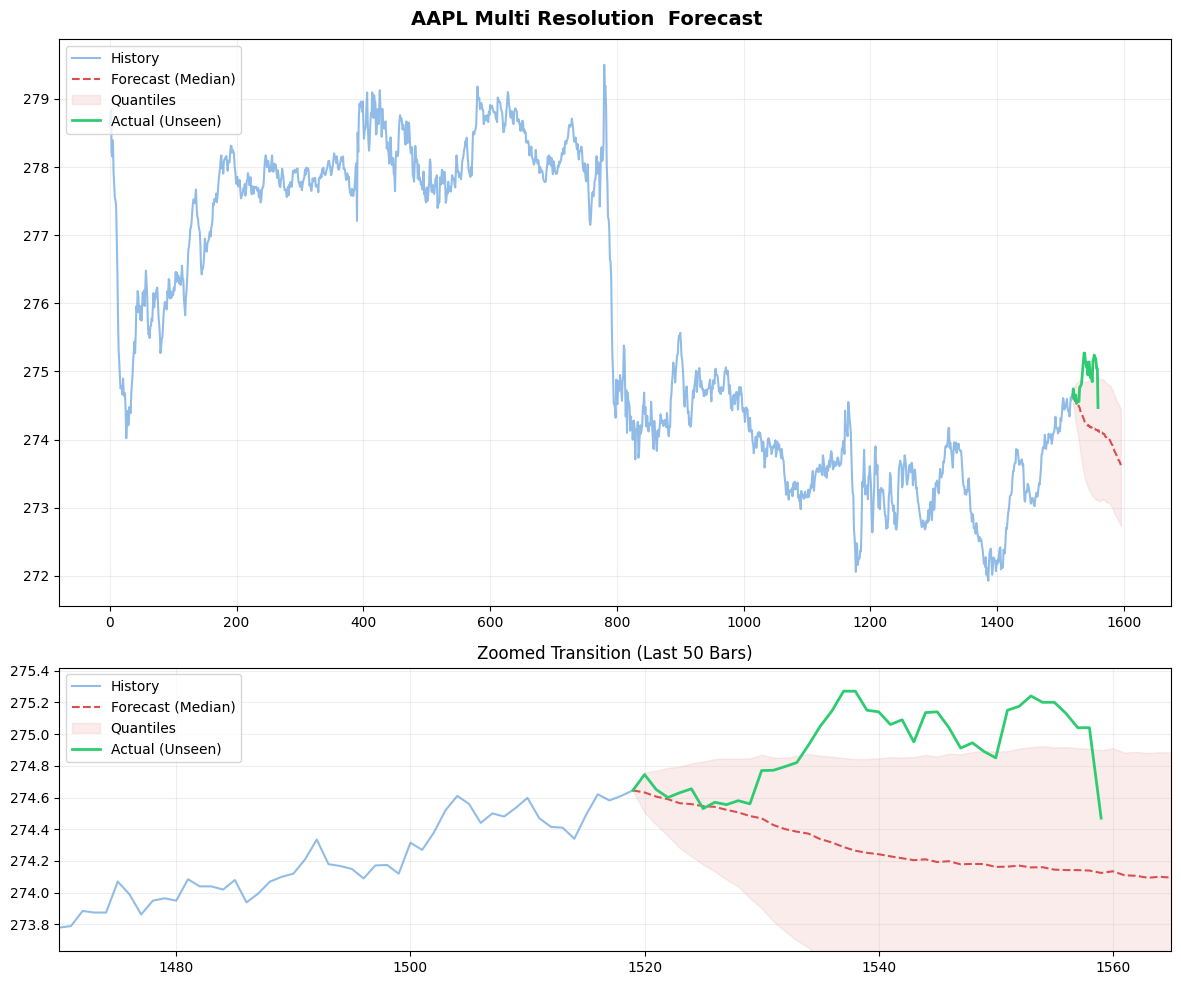

🎨 log: Aligned visualization rendered.
✅ log: Run for AAPL completed successfully.
--- 🏁 log: Run for AAPL concluded. Cleaning up... ---


In [13]:
run_single_asset_forecast('AAPL')

# GOOGLE


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: GOOGL (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for GOOGL...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for GOOGL. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for GOOGL...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 1560 | Coarse points: 1738
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.851714
📉 log: RMSE: 0.952109
🚀 log: Multiresolution forecast complete for GOOGL.
🎨 log: Correcting alignment and rendering visualization...


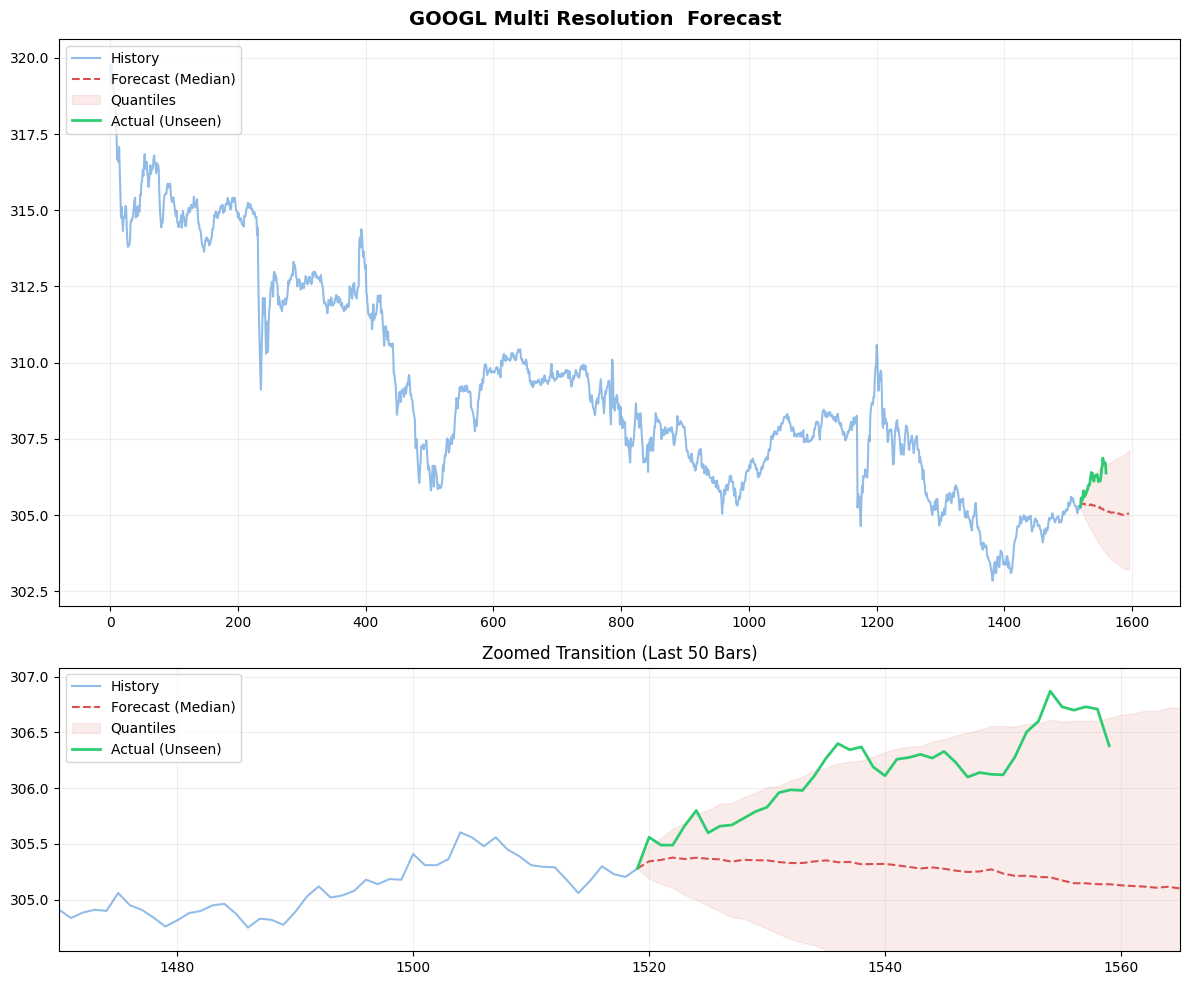

🎨 log: Aligned visualization rendered.
✅ log: Run for GOOGL completed successfully.
--- 🏁 log: Run for GOOGL concluded. Cleaning up... ---


In [14]:
run_single_asset_forecast('GOOGL')

# AMAZON


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: AMZN (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for AMZN...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for AMZN. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for AMZN...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 1560 | Coarse points: 1738
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.419518
📉 log: RMSE: 0.464838
🚀 log: Multiresolution forecast complete for AMZN.
🎨 log: Correcting alignment and rendering visualization...


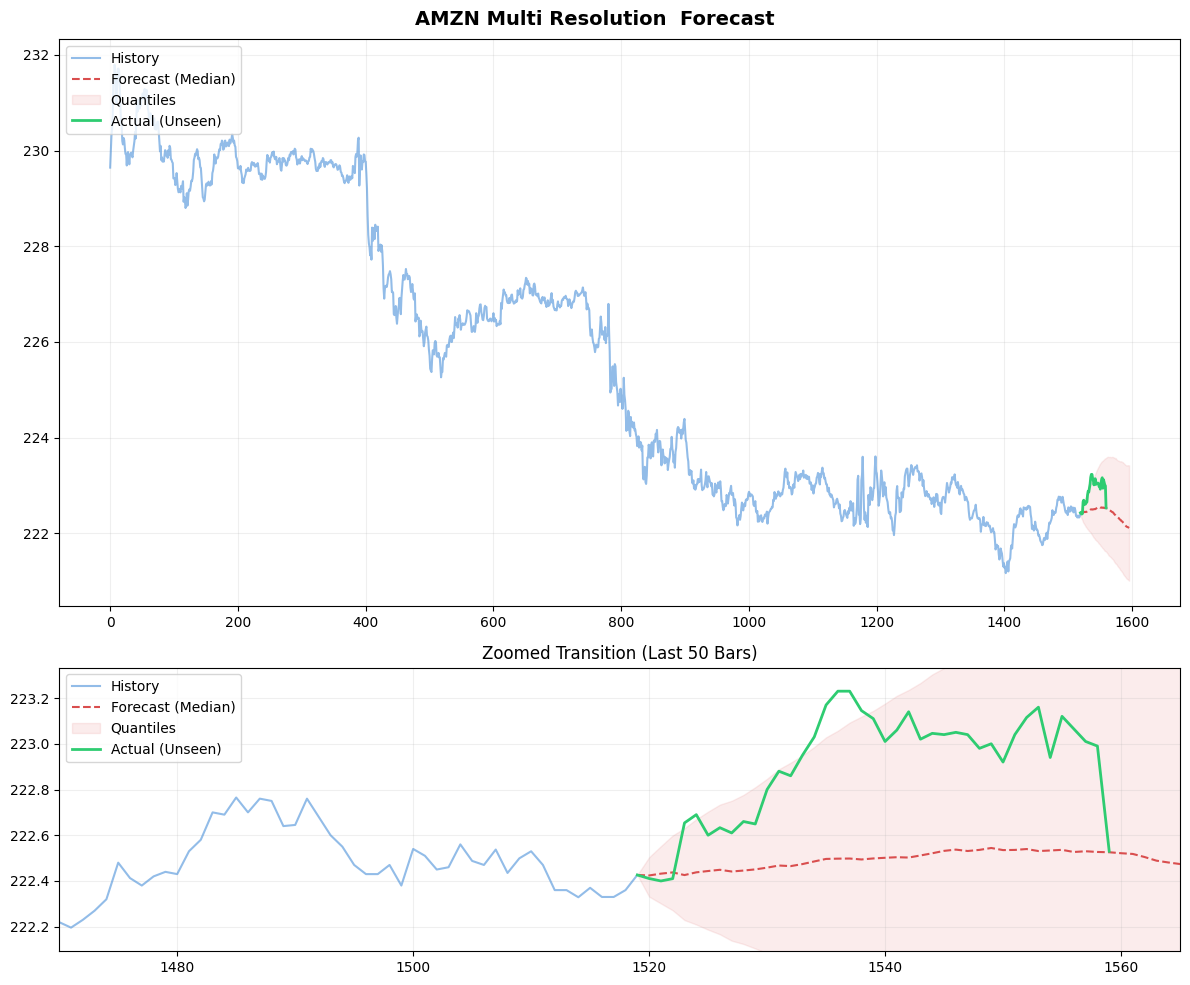

🎨 log: Aligned visualization rendered.
✅ log: Run for AMZN completed successfully.
--- 🏁 log: Run for AMZN concluded. Cleaning up... ---


In [15]:
run_single_asset_forecast('AMZN')

# MICROSOFT


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: MSFT (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for MSFT...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for MSFT. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for MSFT...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 1560 | Coarse points: 1738
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 1.100740
📉 log: RMSE: 1.326947
🚀 log: Multiresolution forecast complete for MSFT.
🎨 log: Correcting alignment and rendering visualization...


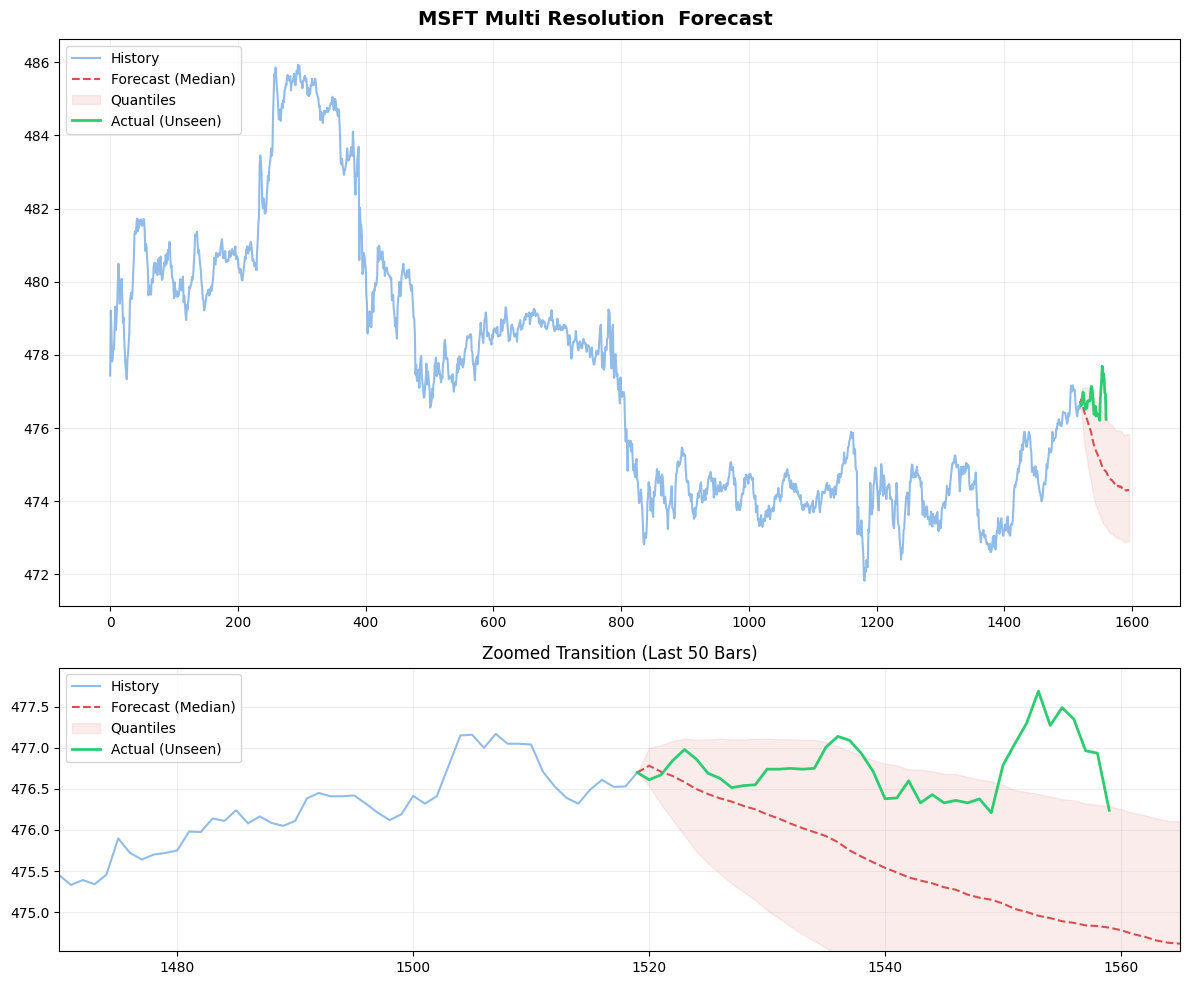

🎨 log: Aligned visualization rendered.
✅ log: Run for MSFT completed successfully.
--- 🏁 log: Run for MSFT concluded. Cleaning up... ---


In [16]:
run_single_asset_forecast('MSFT')

# EURUSD


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: EURUSD=X (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for EURUSD=X...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for EURUSD=X. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for EURUSD=X...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 5645 | Coarse points: 6174
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.000065
📉 log: RMSE: 0.000078
🚀 log: Multiresolution forecast complete for EURUSD=X.
🎨 log: Correcting alignment and rendering visualization...


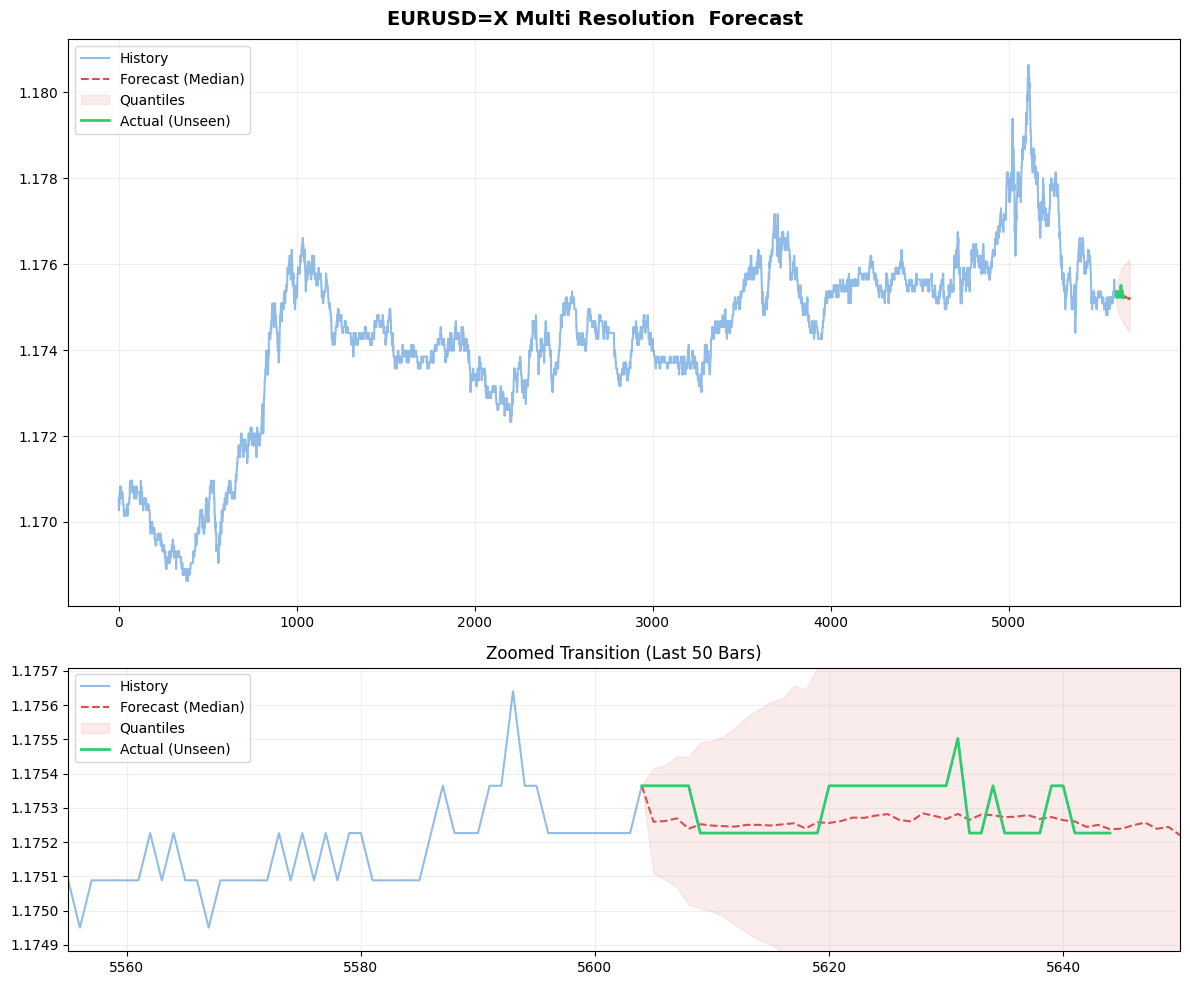

🎨 log: Aligned visualization rendered.
✅ log: Run for EURUSD=X completed successfully.
--- 🏁 log: Run for EURUSD=X concluded. Cleaning up... ---


In [17]:

TICKER = 'EURUSD=X'
run_single_asset_forecast(TICKER)

# GBPUSD


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: GBPUSD=X (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for GBPUSD=X...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for GBPUSD=X. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for GBPUSD=X...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 5645 | Coarse points: 6177
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.000078
📉 log: RMSE: 0.000095
🚀 log: Multiresolution forecast complete for GBPUSD=X.
🎨 log: Correcting alignment and rendering visualization...


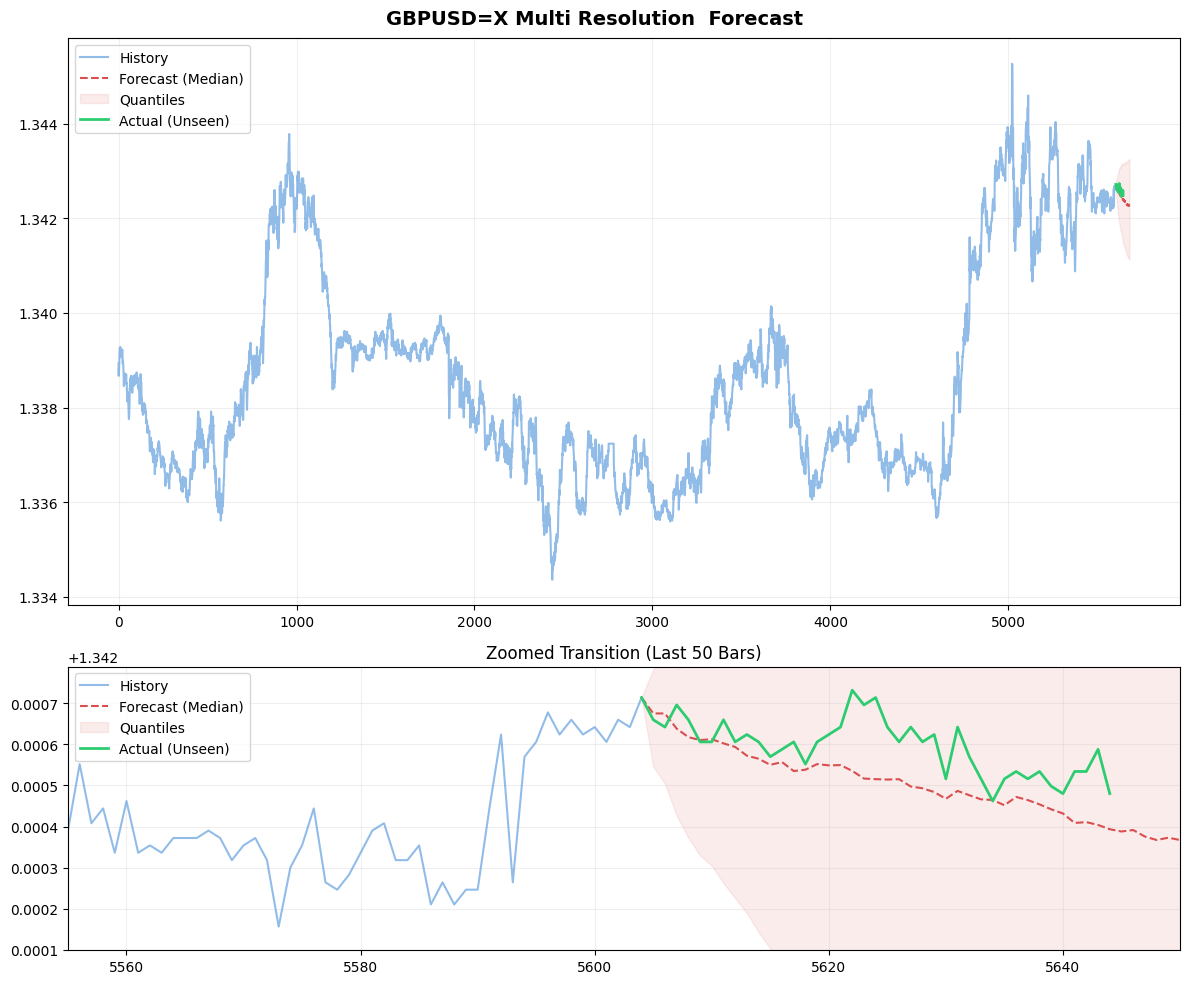

🎨 log: Aligned visualization rendered.
✅ log: Run for GBPUSD=X completed successfully.
--- 🏁 log: Run for GBPUSD=X concluded. Cleaning up... ---


In [18]:
TICKER = 'GBPUSD=X'
run_single_asset_forecast(TICKER)

# USDJPY


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: USDJPY=X (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for USDJPY=X...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for USDJPY=X. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for USDJPY=X...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 5636 | Coarse points: 6137
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.013264
📉 log: RMSE: 0.016752
🚀 log: Multiresolution forecast complete for USDJPY=X.
🎨 log: Correcting alignment and rendering visualization...


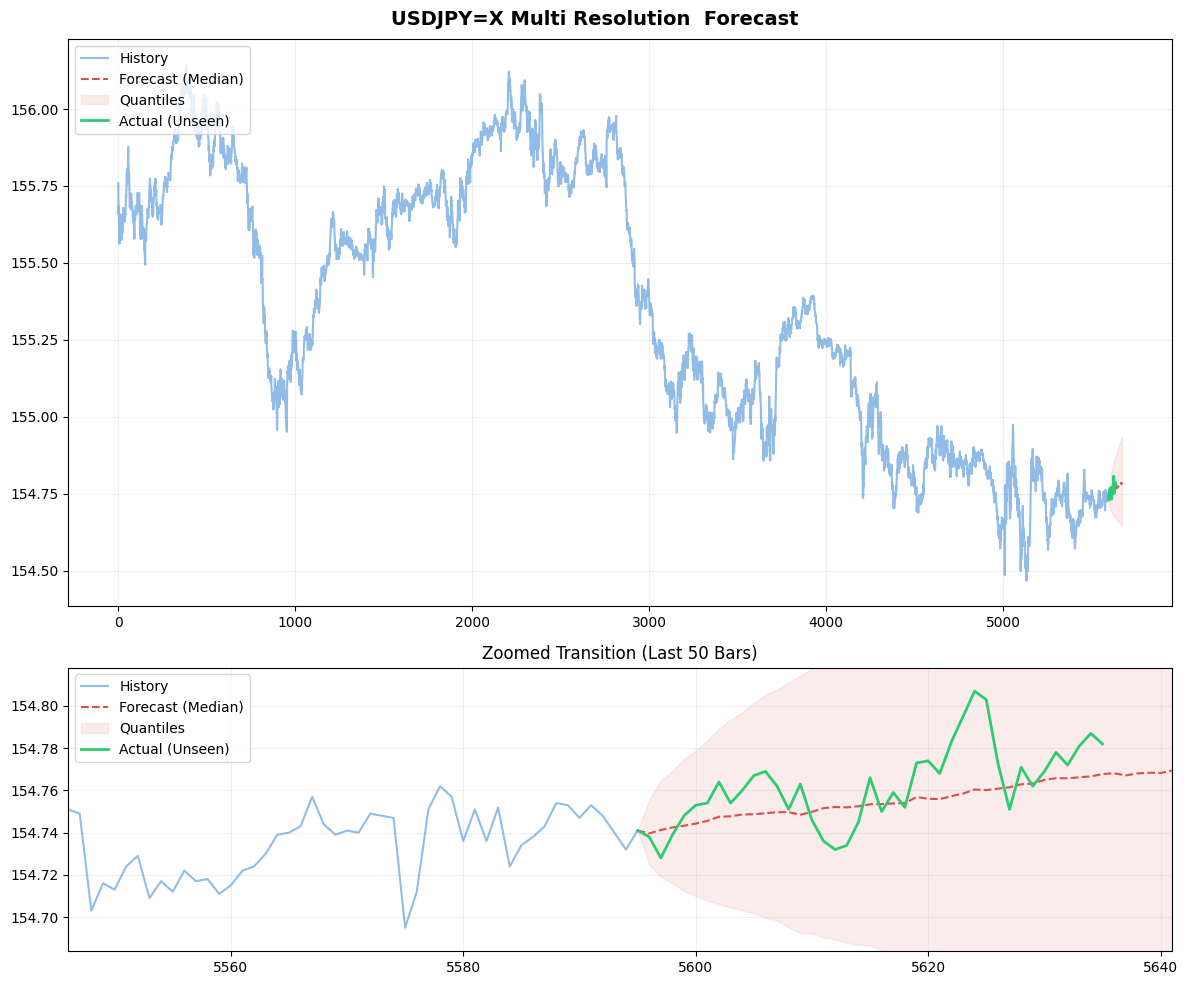

🎨 log: Aligned visualization rendered.
✅ log: Run for USDJPY=X completed successfully.
--- 🏁 log: Run for USDJPY=X concluded. Cleaning up... ---


In [19]:
TICKER = 'USDJPY=X'
run_single_asset_forecast(TICKER)

# BTC-USD


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: BTC-USD (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for BTC-USD...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for BTC-USD. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for BTC-USD...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 7107 | Coarse points: 8728
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 49.679688
📉 log: RMSE: 59.983143
🚀 log: Multiresolution forecast complete for BTC-USD.
🎨 log: Correcting alignment and rendering visualization...


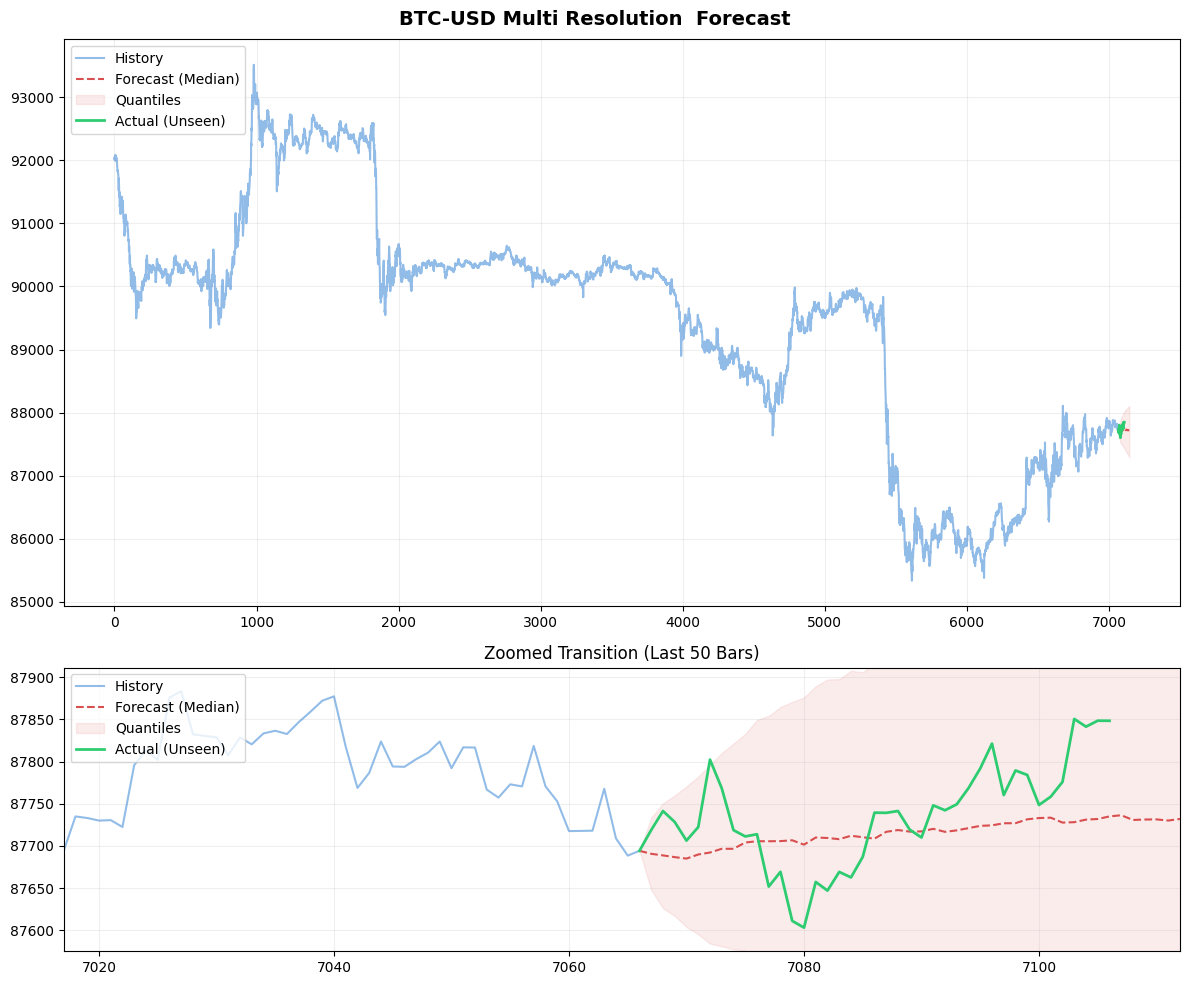

🎨 log: Aligned visualization rendered.
✅ log: Run for BTC-USD completed successfully.
--- 🏁 log: Run for BTC-USD concluded. Cleaning up... ---


In [20]:
TICKER = 'BTC-USD'
run_single_asset_forecast(TICKER)

# ETH USD


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: ETH-USD (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for ETH-USD...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for ETH-USD. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for ETH-USD...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 7174 | Coarse points: 8725
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 4.385993
📉 log: RMSE: 5.452256
🚀 log: Multiresolution forecast complete for ETH-USD.
🎨 log: Correcting alignment and rendering visualization...


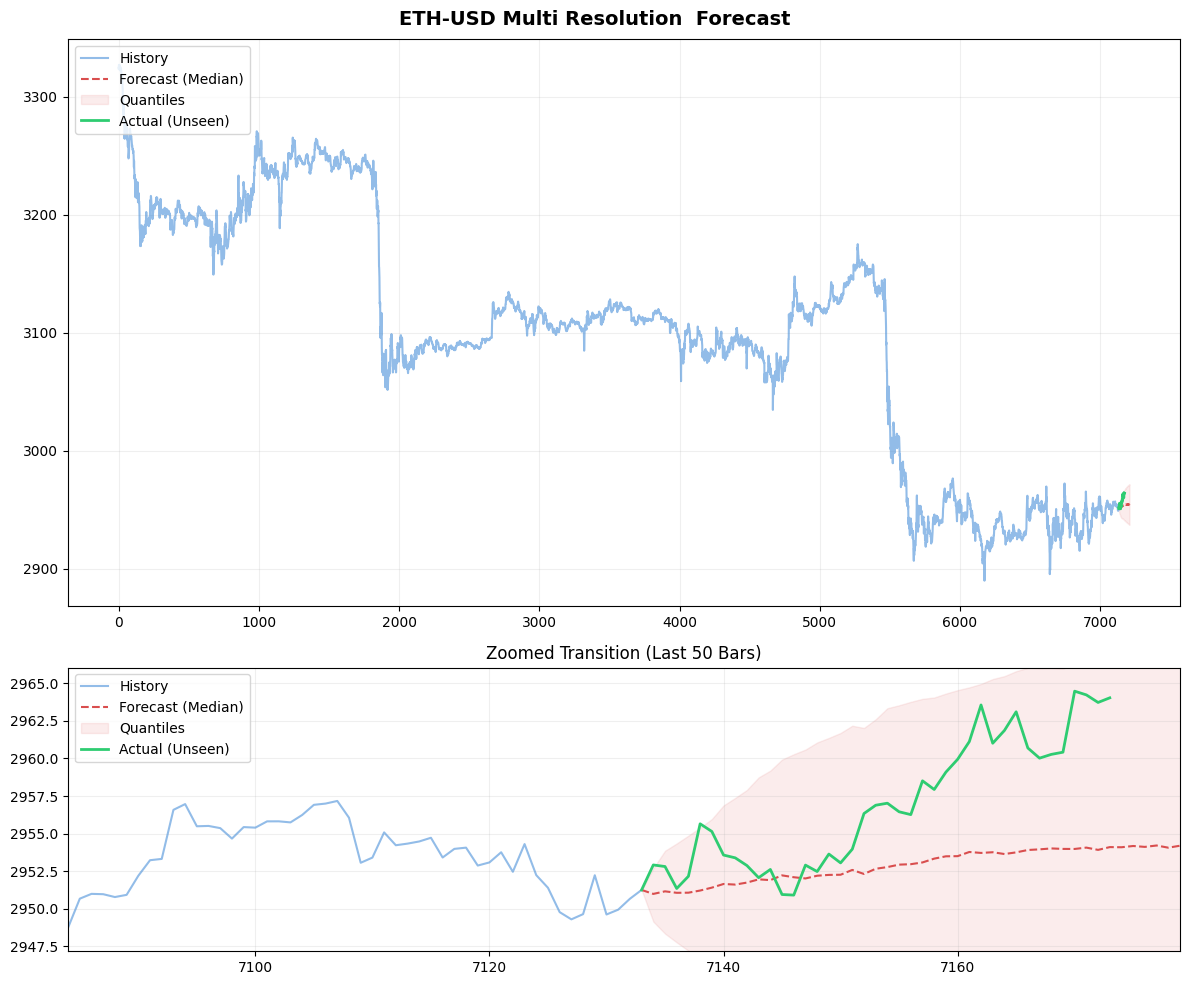

🎨 log: Aligned visualization rendered.
✅ log: Run for ETH-USD completed successfully.
--- 🏁 log: Run for ETH-USD concluded. Cleaning up... ---


In [21]:
TICKER = 'ETH-USD'
run_single_asset_forecast(TICKER)

# SOL USD


--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: SOL-USD (YFinance) ---
📊 log: Model will predict 76 points and compare against 40 actual points.
⚙️ log: Initializing parameters for SOL-USD...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for SOL-USD. Holdout set: 40
🚀 log: Initiating YFinance dual-resolution pipeline...
🏁 log: Pipeline execution started for SOL-USD...
📥 log: Fetching yfinance 1m (Fine) and 1h (Coarse)...
📊 log: Data aligned. Fine points: 5902 | Coarse points: 8727
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 40 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 76...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE: 0.342724
📉 log: RMSE: 0.386071
🚀 log: Multiresolution forecast complete for SOL-USD.
🎨 log: Correcting alignment and rendering visualization...


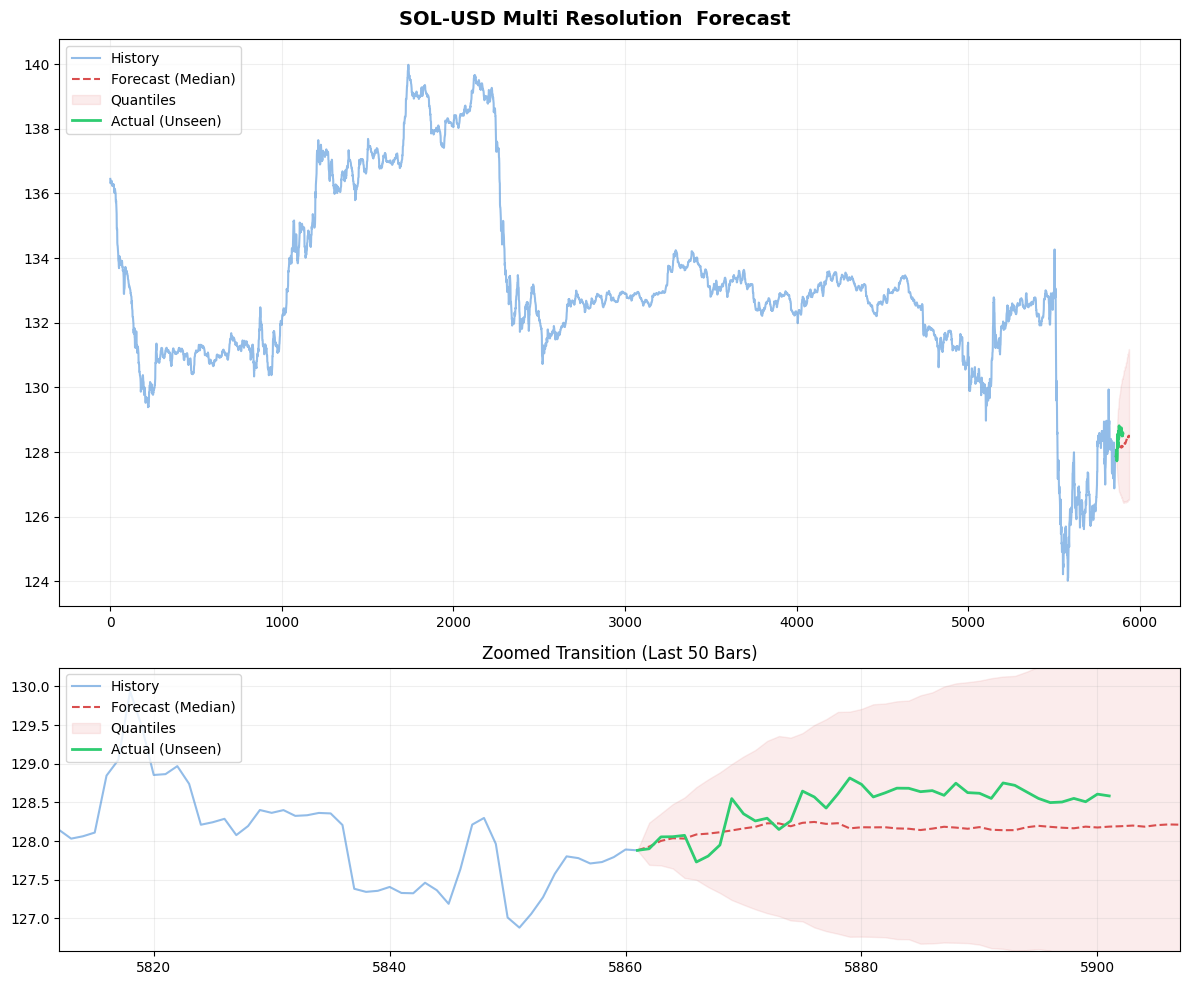

🎨 log: Aligned visualization rendered.
✅ log: Run for SOL-USD completed successfully.
--- 🏁 log: Run for SOL-USD concluded. Cleaning up... ---


In [22]:
TICKER = 'SOL-USD'
run_single_asset_forecast(TICKER)

# Deriv Volatility 10 Index



#####################################################
🚀 Running Deriv Multiresolution Forecast for R_10
#####################################################

--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: R_10 (Deriv) ---
📊 log: Model will predict 90 points and compare against 60 actual points.
⚙️ log: Initializing parameters for R_10...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for R_10. Holdout set: 60
🚀 log: Initiating Deriv dual-resolution pipeline...
🏁 log: Pipeline execution started for R_10...
📥 log: Fetching Deriv 60s and 3600s...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 candles for R_10...
✅ Loaded 5000 points.
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 candles for R_10...
✅ Loaded 5000 points.
✅ log: Successfully synced 5000 fine points.
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 60 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 90...
📊 log: --- METRICS (Unseen Data) ---
📉 log: MAE

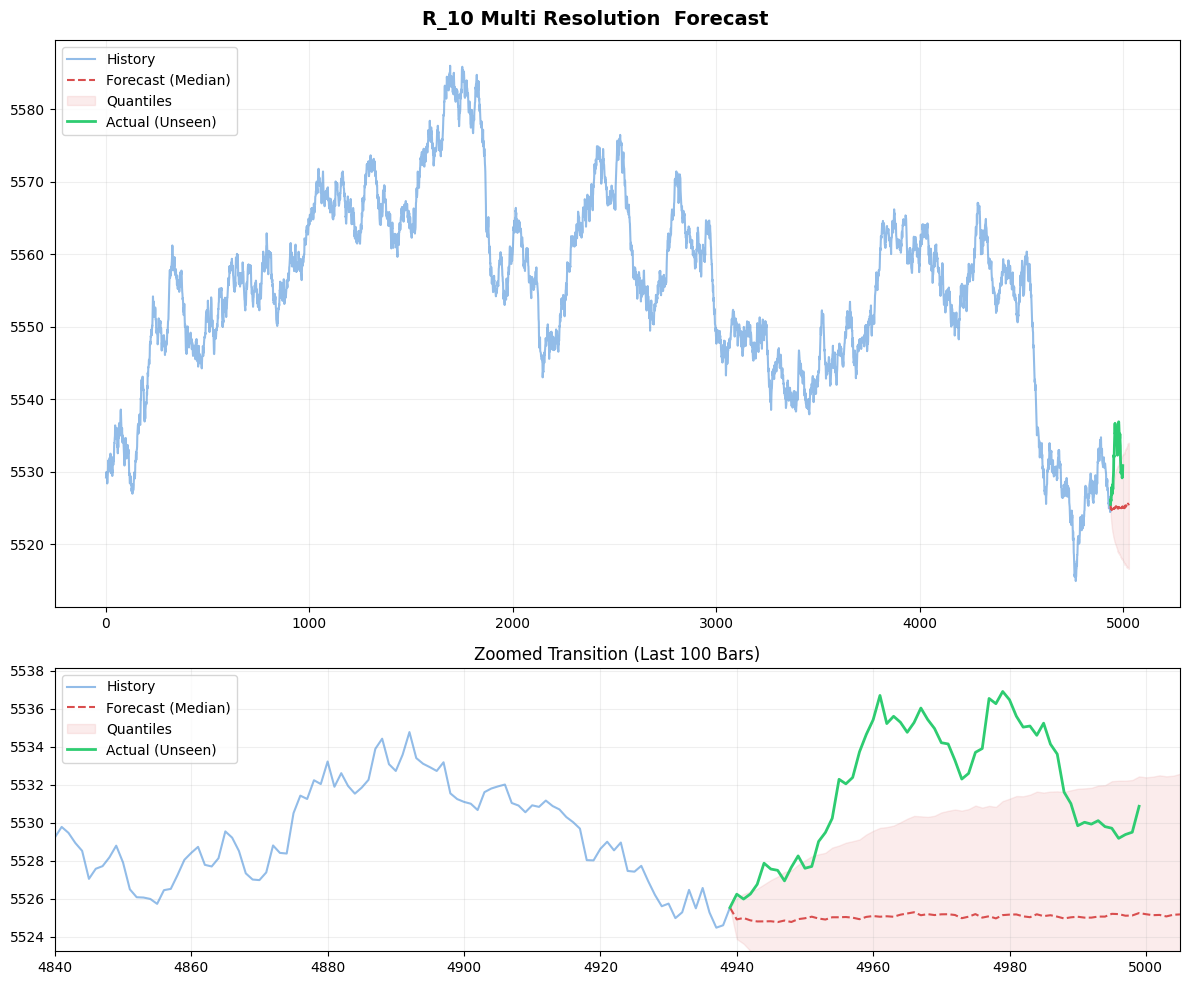

🎨 log: Aligned visualization rendered.
✅ log: Run for R_10 completed successfully.
--- 🏁 log: Run for R_10 concluded. Cleaning up... ---

✨ log: Multiresolution pipeline for R_10 finished processing.


In [23]:
# 📈 Configuration for Deriv
DERIV_TICKER = "R_10"             # 📈 Volatility 10 Index
FINE_GRANULARITY = 60             # 🕒 1 Minute in seconds (Fine)
COARSE_GRANULARITY = 3600         # 📅 1 Hour in seconds (Coarse context)
OHLC_COUNT = 5000                 # 💾 Candles to fetch for both resolutions

# 🧪 Validation Settings
PREDICTION_HORIZON = 90           # 🔮 How many steps to forecast into the future
VALIDATION_STEPS = 60             # 📏 How many actual data points to withhold for comparison

print("\n\n#####################################################")
print(f"🚀 Running Deriv Multiresolution Forecast for {DERIV_TICKER}")
print("#####################################################")

# 🏃 Execution
# Note: We use FINE_START and COARSE_START defined in the previous block
run_single_asset_forecast(
    ticker=DERIV_TICKER,
    fine_start=FINE_START,           # ✨ Fixed variable name to match global
    coarse_start=COARSE_START,       # ✨ Fixed variable name to match global
    end_date=END_DATE,
    deriv=True,                      # 🔌 Using Deriv Source
    count=OHLC_COUNT,
    fine_gran=FINE_GRANULARITY,      # ⏱️ 60s
    coarse_gran=COARSE_GRANULARITY,  # 🏛️ 3600s
    prediction_length=PREDICTION_HORIZON, # 🔮 Total prediction window
    holdout_points=VALIDATION_STEPS,      # 🛑 Hidden from model to compare "Actual vs Predicted"
    zoom_bars=100                    # 🔍 UI Zoom level for the plot
)

print(f"\n✨ log: Multiresolution pipeline for {DERIV_TICKER} finished processing.")



#####################################################
🚀 Running Deriv Multiresolution Forecast for CRASH1000
#####################################################

--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: CRASH1000 (Deriv) ---
📊 log: Model will predict 90 points and compare against 60 actual points.
⚙️ log: Initializing parameters for CRASH1000...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for CRASH1000. Holdout set: 60
🚀 log: Initiating Deriv dual-resolution pipeline...
🏁 log: Pipeline execution started for CRASH1000...
📥 log: Fetching Deriv 60s and 3600s...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 candles for CRASH1000...
✅ Loaded 5000 points.
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 candles for CRASH1000...
✅ Loaded 5000 points.
✅ log: Successfully synced 5000 fine points.
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 60 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 90...
📊 log: --- METRICS (Unseen 

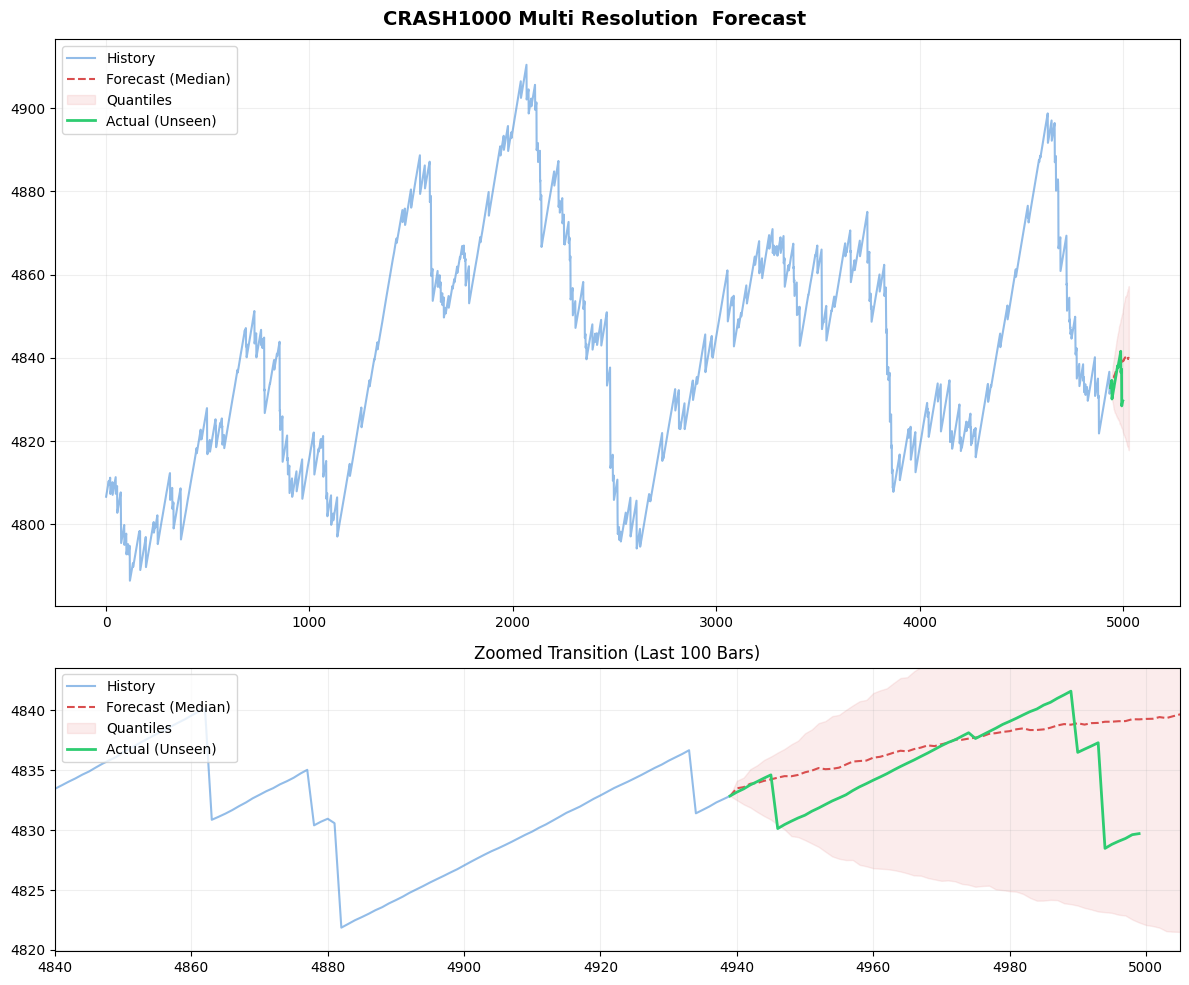

🎨 log: Aligned visualization rendered.
✅ log: Run for CRASH1000 completed successfully.
--- 🏁 log: Run for CRASH1000 concluded. Cleaning up... ---

✨ log: Multiresolution pipeline for CRASH1000 finished processing.


In [24]:
DERIV_TICKER = "CRASH1000"         # 📈 Volatility 100 Index (VIX equivalent)
FINE_GRANULARITY = 60             # 🕒 1 Minute in seconds (Fine)
COARSE_GRANULARITY = 3600         # 📅 1 Hour in seconds (Coarse context)
OHLC_COUNT = 5000                 # 💾 Candles to fetch for both resolutions

# 🧪 Validation Settings
PREDICTION_HORIZON = 90           # 🔮 How many steps to forecast into the future
VALIDATION_STEPS = 60             # 📏 How many actual data points to withhold for comparison

print("\n\n#####################################################")
print(f"🚀 Running Deriv Multiresolution Forecast for {DERIV_TICKER}")
print("#####################################################")

# 🏃 Execution
# Note: We use FINE_START and COARSE_START defined in the previous block
run_single_asset_forecast(
    ticker=DERIV_TICKER,
    fine_start=FINE_START,           # ✨ Fixed variable name to match global
    coarse_start=COARSE_START,       # ✨ Fixed variable name to match global
    end_date=END_DATE,
    deriv=True,                      # 🔌 Using Deriv Source
    count=OHLC_COUNT,
    fine_gran=FINE_GRANULARITY,      # ⏱️ 60s
    coarse_gran=COARSE_GRANULARITY,  # 🏛️ 3600s
    prediction_length=PREDICTION_HORIZON, # 🔮 Total prediction window
    holdout_points=VALIDATION_STEPS,      # 🛑 Hidden from model to compare "Actual vs Predicted"
    zoom_bars=100                    # 🔍 UI Zoom level for the plot
)

print(f"\n✨ log: Multiresolution pipeline for {DERIV_TICKER} finished processing.")



#####################################################
🚀 Running Deriv Multiresolution Forecast for BOOM1000
#####################################################

--- 🏭 log: Starting CiscoTsm MR-Model run for Ticker: BOOM1000 (Deriv) ---
📊 log: Model will predict 90 points and compare against 60 actual points.
⚙️ log: Initializing parameters for BOOM1000...
🧠 log: Loading model architecture and weights...


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 log: CiscoTsmMR model and weights loaded successfully.
✨ log: CiscoTsm Forecaster ready for BOOM1000. Holdout set: 60
🚀 log: Initiating Deriv dual-resolution pipeline...
🏁 log: Pipeline execution started for BOOM1000...
📥 log: Fetching Deriv 60s and 3600s...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 candles for BOOM1000...
✅ Loaded 5000 points.
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 candles for BOOM1000...
✅ Loaded 5000 points.
✅ log: Successfully synced 5000 fine points.
🏁 log: Starting Multiresolution Prediction & Validation...
✂️ log: Sliced 60 points into holdout set for validation.
🔮 log: Generating forecast for horizon: 90...
📊 log: --- METRICS (Unseen Data

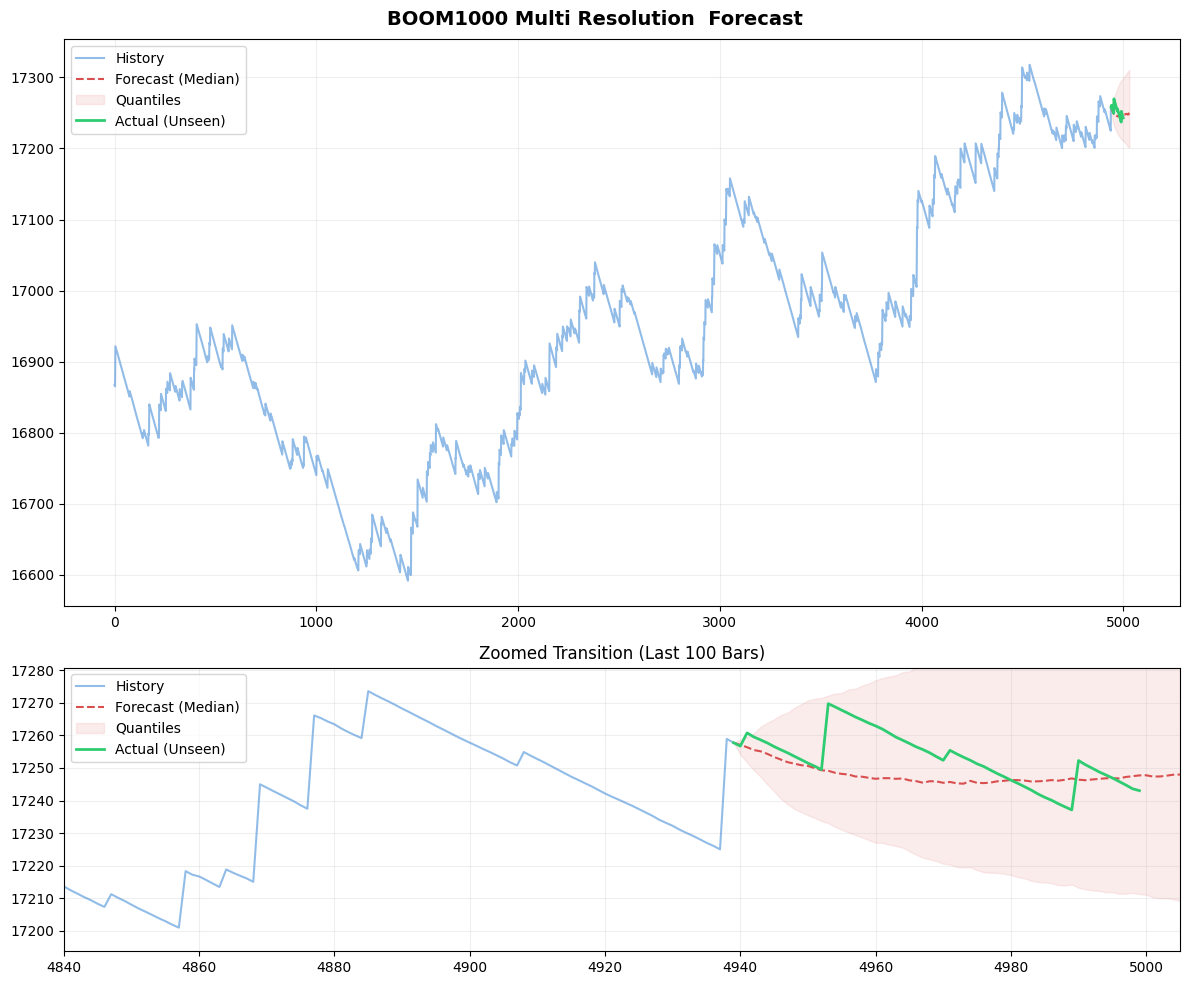

🎨 log: Aligned visualization rendered.
✅ log: Run for BOOM1000 completed successfully.
--- 🏁 log: Run for BOOM1000 concluded. Cleaning up... ---

✨ log: Multiresolution pipeline for BOOM1000 finished processing.


In [25]:
# 📈 Asset Configuration
DERIV_TICKER = "BOOM1000"         # Synthetic Index
FINE_GRANULARITY = 60             # 🕒 1 Minute in seconds (Fine)
COARSE_GRANULARITY = 3600         # 📅 1 Hour in seconds (Coarse context)
OHLC_COUNT = 5000                 # 💾 Candles to fetch for both resolutions

# 🧪 Validation Settings
PREDICTION_HORIZON = 90           # 🔮 How many steps to forecast into the future
VALIDATION_STEPS = 60             # 📏 How many actual data points to withhold for comparison

print("\n\n#####################################################")
print(f"🚀 Running Deriv Multiresolution Forecast for {DERIV_TICKER}")
print("#####################################################")

# 🏃 Execution
# Note: We use FINE_START and COARSE_START defined in the previous block
run_single_asset_forecast(
    ticker=DERIV_TICKER,
    fine_start=FINE_START,           # ✨ Fixed variable name to match global
    coarse_start=COARSE_START,       # ✨ Fixed variable name to match global
    end_date=END_DATE,
    deriv=True,                      # 🔌 Using Deriv Source
    count=OHLC_COUNT,
    fine_gran=FINE_GRANULARITY,      # ⏱️ 60s
    coarse_gran=COARSE_GRANULARITY,  # 🏛️ 3600s
    prediction_length=PREDICTION_HORIZON, # 🔮 Total prediction window
    holdout_points=VALIDATION_STEPS,      # 🛑 Hidden from model to compare "Actual vs Predicted"
    zoom_bars=100                    # 🔍 UI Zoom level for the plot
)

print(f"\n✨ log: Multiresolution pipeline for {DERIV_TICKER} finished processing.")